In [42]:
import numpy as np
import pandas as pd
from transformers import pipeline

In [43]:
df = pd.read_csv("../Data/preprocessed_osteoporosis_11labels.csv")#load labeled data
df = df[:99]#only labeled 99 records

In [44]:
#replace NaN in label columns with 0
columns = ['limb pain','gastrointestinal', 'dental', 'cardiac', 'dermatological',
       'respiratory', 'weight gain and loss', 'headache', 'menstrual',
       'fatigue', 'body temperature']

for column in columns:
    df[column] = df[column].replace(np.nan, int(0))

#extract column "Reviews" and label columns for tuning
df = df[['Reviews','limb pain','gastrointestinal', 'dental', 'cardiac', 'dermatological',
       'respiratory', 'weight gain and loss', 'headache', 'menstrual',
       'fatigue', 'body temperature' ]]

In [45]:
#train/val/test split
df_train = df.iloc[:60]
df_val = df.iloc[60:80]
df_test = df.iloc[80:]

df_train.to_csv("../Data/train_11labels.csv", index=False)
df_val.to_csv("../Data/val_11labels.csv", index=False)
df_test.to_csv("../Data/test_11labels.csv", index=False)

In [46]:
from datasets import load_dataset

dataset = load_dataset("csv", data_files={"train": "../Data/train_11labels.csv", "val": "../Data/val_11labels.csv", "test": "../Data/test_11labels.csv"})

Using custom data configuration default-25d500c4b8ee1ef6


Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

0 tables [00:00, ? tables/s]

0 tables [00:00, ? tables/s]

Dataset csv downloaded and prepared to C:\Users\Woon.Kim\.cache\huggingface\datasets\csv\default-25d500c4b8ee1ef6\0.0.0\652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [47]:
from transformers import BartTokenizer

labels = ['limb pain', 'gastrointestinal', 'dental', 'cardiac', 'dermatological',
       'respiratory', 'weight gain and loss', 'headache', 'menstrual',
       'fatigue', 'body temperature']
       
tokenizer = BartTokenizer.from_pretrained("facebook/bart-large-mnli")

def preprocess_data(examples):
  # take a batch of texts
  text = examples["Reviews"]
  # encode them
  encoding = tokenizer(text, padding="max_length", truncation=True, max_length=128)
  # add labels
  labels_batch = {k: examples[k] for k in examples.keys() if k in labels}
  # create numpy array of shape (batch_size, num_labels)
  labels_matrix = np.zeros((len(text), len(labels)))
  # fill numpy array
  for idx, label in enumerate(labels):
    labels_matrix[:, idx] = labels_batch[label]

  encoding["labels"] = labels_matrix.tolist()
  
  return encoding

loading file https://huggingface.co/facebook/bart-large-mnli/resolve/main/vocab.json from cache at C:\Users\Woon.Kim/.cache\huggingface\transformers\b4f8395edd321fd7cd8a87bca767b1135680a41d8931516dd1a447294633b9db.647b4548b6d9ea817e82e7a9231a320231a1c9ea24053cc9e758f3fe68216f05
loading file https://huggingface.co/facebook/bart-large-mnli/resolve/main/merges.txt from cache at C:\Users\Woon.Kim/.cache\huggingface\transformers\19c09c9654551e163f858f3c99c226a8d0026acc4935528df3b09179204efe4c.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b
loading file https://huggingface.co/facebook/bart-large-mnli/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/facebook/bart-large-mnli/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/facebook/bart-large-mnli/resolve/main/tokenizer_config.json from cache at C:\Users\Woon.Kim/.cache\huggingface\transformers\569800088d6f014777e6d5d8cb61b2b8bb3d18a508a1d8af041aae

In [48]:
from transformers import BartForSequenceClassification

#define the model
model = BartForSequenceClassification.from_pretrained("facebook/bart-large-mnli",problem_type="multi_label_classification", num_labels=11, ignore_mismatched_sizes=True)

loading configuration file https://huggingface.co/facebook/bart-large-mnli/resolve/main/config.json from cache at C:\Users\Woon.Kim/.cache\huggingface\transformers\980f2be6bd282c5079e99199d7554cfd13000433ed0fdc527e7def799e5738fe.4fdc7ce6768977d347b32986aff152e26fcebbda34ef89ac9b114971d0342e09
Model config BartConfig {
  "_num_labels": 3,
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "add_final_layer_norm": false,
  "architectures": [
    "BartForSequenceClassification"
  ],
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classif_dropout": 0.0,
  "classifier_dropout": 0.0,
  "d_model": 1024,
  "decoder_attention_heads": 16,
  "decoder_ffn_dim": 4096,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 12,
  "decoder_start_token_id": 2,
  "dropout": 0.1,
  "encoder_attention_heads": 16,
  "encoder_ffn_dim": 4096,
  "encoder_layerdrop": 0.0,
  "encoder_layers": 12,
  "eos_token_id": 2,
  "forced_eos_token_id": 2,
  "gradient_checkpointing": false,
  "id2label": {
    "0"

In [49]:
#declare training hyperparameters
from transformers import TrainingArguments

training_args = TrainingArguments(output_dir="../Output/Model",
                                learning_rate=1e-4,
                                evaluation_strategy="epoch",
                                per_device_train_batch_size=8,
                                per_device_eval_batch_size=8,
                                num_train_epochs=30,
                                weight_decay=0.01,
                                metric_for_best_model="accuracy",
                                # save_strategy="epoch",
                                # load_best_model_at_end=True

)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [50]:
#define a compute_metrics function that returns a dictionary with the desired metric values
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from transformers import EvalPrediction
import torch

def multi_label_metrics(predictions, labels, threshold=0.5):
  sigmoid = torch.nn.Sigmoid()
  probs = sigmoid(torch.Tensor(predictions))
  y_pred = np.zeros(probs.shape)
  y_pred[np.where(probs >= threshold)] = 1
  y_true = labels
  f1_micro_average = f1_score(y_true, y_pred, average="weighted") 
  roc_auc = roc_auc_score(y_true, y_pred, average="micro") 
  accuracy = accuracy_score(y_true, y_pred)

  metrics = {"f1": f1_micro_average,
             "roc_auc": roc_auc,
             "accuracy": accuracy}
  return metrics

def compute_metrics(p: EvalPrediction):
  preds = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions
  result = multi_label_metrics(predictions=preds, labels=p.label_ids)
  return result

In [51]:
#trainer
from transformers import Trainer

trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset = encoded_dataset["train"],
    eval_dataset = encoded_dataset["val"],
    tokenizer = tokenizer,
    compute_metrics = compute_metrics
)

In [52]:
#fine-tune BART model by calling train()
trainer.train()

c:\Users\Woon.Kim\Anaconda33\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 60
  Num Epochs = 30
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 240


  0%|          | 0/240 [00:00<?, ?it/s]

***** Running Evaluation *****
  Num examples = 20
  Batch size = 8


  0%|          | 0/3 [00:00<?, ?it/s]

c:\Users\Woon.Kim\Anaconda33\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


{'eval_loss': 0.39419442415237427, 'eval_f1': 0.0, 'eval_roc_auc': 0.5, 'eval_accuracy': 0.25, 'eval_runtime': 16.1584, 'eval_samples_per_second': 1.238, 'eval_steps_per_second': 0.186, 'epoch': 1.0}


***** Running Evaluation *****
  Num examples = 20
  Batch size = 8


  0%|          | 0/3 [00:00<?, ?it/s]

c:\Users\Woon.Kim\Anaconda33\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


{'eval_loss': 0.38435232639312744, 'eval_f1': 0.0, 'eval_roc_auc': 0.5, 'eval_accuracy': 0.25, 'eval_runtime': 16.1118, 'eval_samples_per_second': 1.241, 'eval_steps_per_second': 0.186, 'epoch': 2.0}


***** Running Evaluation *****
  Num examples = 20
  Batch size = 8


  0%|          | 0/3 [00:00<?, ?it/s]

c:\Users\Woon.Kim\Anaconda33\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


{'eval_loss': 0.32947179675102234, 'eval_f1': 0.3506493506493507, 'eval_roc_auc': 0.6684491978609627, 'eval_accuracy': 0.35, 'eval_runtime': 16.0988, 'eval_samples_per_second': 1.242, 'eval_steps_per_second': 0.186, 'epoch': 3.0}


***** Running Evaluation *****
  Num examples = 20
  Batch size = 8


  0%|          | 0/3 [00:00<?, ?it/s]

c:\Users\Woon.Kim\Anaconda33\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


{'eval_loss': 0.3595520853996277, 'eval_f1': 0.0404040404040404, 'eval_roc_auc': 0.5098039215686274, 'eval_accuracy': 0.25, 'eval_runtime': 16.1288, 'eval_samples_per_second': 1.24, 'eval_steps_per_second': 0.186, 'epoch': 4.0}


***** Running Evaluation *****
  Num examples = 20
  Batch size = 8


  0%|          | 0/3 [00:00<?, ?it/s]

c:\Users\Woon.Kim\Anaconda33\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


{'eval_loss': 0.32130202651023865, 'eval_f1': 0.43512043512043513, 'eval_roc_auc': 0.6934046345811052, 'eval_accuracy': 0.45, 'eval_runtime': 16.1002, 'eval_samples_per_second': 1.242, 'eval_steps_per_second': 0.186, 'epoch': 5.0}


***** Running Evaluation *****
  Num examples = 20
  Batch size = 8


  0%|          | 0/3 [00:00<?, ?it/s]

c:\Users\Woon.Kim\Anaconda33\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


{'eval_loss': 0.30139851570129395, 'eval_f1': 0.4049586776859504, 'eval_roc_auc': 0.6916221033868093, 'eval_accuracy': 0.45, 'eval_runtime': 16.085, 'eval_samples_per_second': 1.243, 'eval_steps_per_second': 0.187, 'epoch': 6.0}


***** Running Evaluation *****
  Num examples = 20
  Batch size = 8


  0%|          | 0/3 [00:00<?, ?it/s]

c:\Users\Woon.Kim\Anaconda33\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


{'eval_loss': 0.32799631357192993, 'eval_f1': 0.49263689526847426, 'eval_roc_auc': 0.7299465240641712, 'eval_accuracy': 0.35, 'eval_runtime': 16.057, 'eval_samples_per_second': 1.246, 'eval_steps_per_second': 0.187, 'epoch': 7.0}


***** Running Evaluation *****
  Num examples = 20
  Batch size = 8


  0%|          | 0/3 [00:00<?, ?it/s]

c:\Users\Woon.Kim\Anaconda33\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


{'eval_loss': 0.2727731764316559, 'eval_f1': 0.5049657413293777, 'eval_roc_auc': 0.7388591800356507, 'eval_accuracy': 0.4, 'eval_runtime': 16.1888, 'eval_samples_per_second': 1.235, 'eval_steps_per_second': 0.185, 'epoch': 8.0}


***** Running Evaluation *****
  Num examples = 20
  Batch size = 8


  0%|          | 0/3 [00:00<?, ?it/s]

c:\Users\Woon.Kim\Anaconda33\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


{'eval_loss': 0.3015553057193756, 'eval_f1': 0.5838383838383838, 'eval_roc_auc': 0.7887700534759358, 'eval_accuracy': 0.5, 'eval_runtime': 16.2115, 'eval_samples_per_second': 1.234, 'eval_steps_per_second': 0.185, 'epoch': 9.0}


***** Running Evaluation *****
  Num examples = 20
  Batch size = 8


  0%|          | 0/3 [00:00<?, ?it/s]

c:\Users\Woon.Kim\Anaconda33\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


{'eval_loss': 0.2945452630519867, 'eval_f1': 0.5359351086623814, 'eval_roc_auc': 0.7219251336898396, 'eval_accuracy': 0.55, 'eval_runtime': 16.2333, 'eval_samples_per_second': 1.232, 'eval_steps_per_second': 0.185, 'epoch': 10.0}


***** Running Evaluation *****
  Num examples = 20
  Batch size = 8


  0%|          | 0/3 [00:00<?, ?it/s]

c:\Users\Woon.Kim\Anaconda33\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


{'eval_loss': 0.28405648469924927, 'eval_f1': 0.5749601275917066, 'eval_roc_auc': 0.7593582887700534, 'eval_accuracy': 0.45, 'eval_runtime': 17.089, 'eval_samples_per_second': 1.17, 'eval_steps_per_second': 0.176, 'epoch': 11.0}


***** Running Evaluation *****
  Num examples = 20
  Batch size = 8


  0%|          | 0/3 [00:00<?, ?it/s]

c:\Users\Woon.Kim\Anaconda33\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


{'eval_loss': 0.2747989594936371, 'eval_f1': 0.6091592617908408, 'eval_roc_auc': 0.7664884135472372, 'eval_accuracy': 0.5, 'eval_runtime': 16.1976, 'eval_samples_per_second': 1.235, 'eval_steps_per_second': 0.185, 'epoch': 12.0}


***** Running Evaluation *****
  Num examples = 20
  Batch size = 8


  0%|          | 0/3 [00:00<?, ?it/s]

c:\Users\Woon.Kim\Anaconda33\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


{'eval_loss': 0.2832958400249481, 'eval_f1': 0.6401837928153717, 'eval_roc_auc': 0.7896613190730838, 'eval_accuracy': 0.5, 'eval_runtime': 16.2413, 'eval_samples_per_second': 1.231, 'eval_steps_per_second': 0.185, 'epoch': 13.0}


***** Running Evaluation *****
  Num examples = 20
  Batch size = 8


  0%|          | 0/3 [00:00<?, ?it/s]

c:\Users\Woon.Kim\Anaconda33\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


{'eval_loss': 0.2747882008552551, 'eval_f1': 0.617171717171717, 'eval_roc_auc': 0.7745098039215685, 'eval_accuracy': 0.55, 'eval_runtime': 8.818, 'eval_samples_per_second': 2.268, 'eval_steps_per_second': 0.34, 'epoch': 14.0}


***** Running Evaluation *****
  Num examples = 20
  Batch size = 8


  0%|          | 0/3 [00:00<?, ?it/s]

c:\Users\Woon.Kim\Anaconda33\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


{'eval_loss': 0.277802050113678, 'eval_f1': 0.6843045843045842, 'eval_roc_auc': 0.8048128342245989, 'eval_accuracy': 0.6, 'eval_runtime': 8.9419, 'eval_samples_per_second': 2.237, 'eval_steps_per_second': 0.336, 'epoch': 15.0}


***** Running Evaluation *****
  Num examples = 20
  Batch size = 8


  0%|          | 0/3 [00:00<?, ?it/s]

c:\Users\Woon.Kim\Anaconda33\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


{'eval_loss': 0.287852942943573, 'eval_f1': 0.6501738028053818, 'eval_roc_auc': 0.7923351158645277, 'eval_accuracy': 0.55, 'eval_runtime': 9.8076, 'eval_samples_per_second': 2.039, 'eval_steps_per_second': 0.306, 'epoch': 16.0}


***** Running Evaluation *****
  Num examples = 20
  Batch size = 8


  0%|          | 0/3 [00:00<?, ?it/s]

c:\Users\Woon.Kim\Anaconda33\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


{'eval_loss': 0.28009846806526184, 'eval_f1': 0.6501738028053818, 'eval_roc_auc': 0.7923351158645277, 'eval_accuracy': 0.55, 'eval_runtime': 8.6458, 'eval_samples_per_second': 2.313, 'eval_steps_per_second': 0.347, 'epoch': 17.0}


***** Running Evaluation *****
  Num examples = 20
  Batch size = 8


  0%|          | 0/3 [00:00<?, ?it/s]

c:\Users\Woon.Kim\Anaconda33\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


{'eval_loss': 0.277113139629364, 'eval_f1': 0.6501738028053818, 'eval_roc_auc': 0.7923351158645277, 'eval_accuracy': 0.55, 'eval_runtime': 10.2468, 'eval_samples_per_second': 1.952, 'eval_steps_per_second': 0.293, 'epoch': 18.0}


***** Running Evaluation *****
  Num examples = 20
  Batch size = 8


  0%|          | 0/3 [00:00<?, ?it/s]

c:\Users\Woon.Kim\Anaconda33\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


{'eval_loss': 0.2837141156196594, 'eval_f1': 0.6501738028053818, 'eval_roc_auc': 0.7923351158645277, 'eval_accuracy': 0.55, 'eval_runtime': 7.7415, 'eval_samples_per_second': 2.583, 'eval_steps_per_second': 0.388, 'epoch': 19.0}


***** Running Evaluation *****
  Num examples = 20
  Batch size = 8


  0%|          | 0/3 [00:00<?, ?it/s]

c:\Users\Woon.Kim\Anaconda33\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


{'eval_loss': 0.2859908640384674, 'eval_f1': 0.6501738028053818, 'eval_roc_auc': 0.7923351158645277, 'eval_accuracy': 0.55, 'eval_runtime': 8.5342, 'eval_samples_per_second': 2.344, 'eval_steps_per_second': 0.352, 'epoch': 20.0}


***** Running Evaluation *****
  Num examples = 20
  Batch size = 8


  0%|          | 0/3 [00:00<?, ?it/s]

c:\Users\Woon.Kim\Anaconda33\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


{'eval_loss': 0.2848251461982727, 'eval_f1': 0.6501738028053818, 'eval_roc_auc': 0.7923351158645277, 'eval_accuracy': 0.55, 'eval_runtime': 7.2232, 'eval_samples_per_second': 2.769, 'eval_steps_per_second': 0.415, 'epoch': 21.0}


***** Running Evaluation *****
  Num examples = 20
  Batch size = 8


  0%|          | 0/3 [00:00<?, ?it/s]

c:\Users\Woon.Kim\Anaconda33\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


{'eval_loss': 0.2843303978443146, 'eval_f1': 0.6501738028053818, 'eval_roc_auc': 0.7923351158645277, 'eval_accuracy': 0.55, 'eval_runtime': 8.5204, 'eval_samples_per_second': 2.347, 'eval_steps_per_second': 0.352, 'epoch': 22.0}


***** Running Evaluation *****
  Num examples = 20
  Batch size = 8


  0%|          | 0/3 [00:00<?, ?it/s]

c:\Users\Woon.Kim\Anaconda33\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


{'eval_loss': 0.28086644411087036, 'eval_f1': 0.6501738028053818, 'eval_roc_auc': 0.7923351158645277, 'eval_accuracy': 0.55, 'eval_runtime': 9.7685, 'eval_samples_per_second': 2.047, 'eval_steps_per_second': 0.307, 'epoch': 23.0}


***** Running Evaluation *****
  Num examples = 20
  Batch size = 8


  0%|          | 0/3 [00:00<?, ?it/s]

c:\Users\Woon.Kim\Anaconda33\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


{'eval_loss': 0.27961602807044983, 'eval_f1': 0.6501738028053818, 'eval_roc_auc': 0.7923351158645277, 'eval_accuracy': 0.55, 'eval_runtime': 9.7211, 'eval_samples_per_second': 2.057, 'eval_steps_per_second': 0.309, 'epoch': 24.0}


***** Running Evaluation *****
  Num examples = 20
  Batch size = 8


  0%|          | 0/3 [00:00<?, ?it/s]

c:\Users\Woon.Kim\Anaconda33\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


{'eval_loss': 0.28108349442481995, 'eval_f1': 0.6501738028053818, 'eval_roc_auc': 0.7923351158645277, 'eval_accuracy': 0.55, 'eval_runtime': 9.3614, 'eval_samples_per_second': 2.136, 'eval_steps_per_second': 0.32, 'epoch': 25.0}


***** Running Evaluation *****
  Num examples = 20
  Batch size = 8


  0%|          | 0/3 [00:00<?, ?it/s]

c:\Users\Woon.Kim\Anaconda33\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


{'eval_loss': 0.2824384570121765, 'eval_f1': 0.6501738028053818, 'eval_roc_auc': 0.7923351158645277, 'eval_accuracy': 0.55, 'eval_runtime': 9.354, 'eval_samples_per_second': 2.138, 'eval_steps_per_second': 0.321, 'epoch': 26.0}


***** Running Evaluation *****
  Num examples = 20
  Batch size = 8


  0%|          | 0/3 [00:00<?, ?it/s]

c:\Users\Woon.Kim\Anaconda33\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


{'eval_loss': 0.28284332156181335, 'eval_f1': 0.6501738028053818, 'eval_roc_auc': 0.7923351158645277, 'eval_accuracy': 0.55, 'eval_runtime': 9.4467, 'eval_samples_per_second': 2.117, 'eval_steps_per_second': 0.318, 'epoch': 27.0}


***** Running Evaluation *****
  Num examples = 20
  Batch size = 8


  0%|          | 0/3 [00:00<?, ?it/s]

c:\Users\Woon.Kim\Anaconda33\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


{'eval_loss': 0.28330808877944946, 'eval_f1': 0.6501738028053818, 'eval_roc_auc': 0.7923351158645277, 'eval_accuracy': 0.55, 'eval_runtime': 10.1745, 'eval_samples_per_second': 1.966, 'eval_steps_per_second': 0.295, 'epoch': 28.0}


***** Running Evaluation *****
  Num examples = 20
  Batch size = 8


  0%|          | 0/3 [00:00<?, ?it/s]

c:\Users\Woon.Kim\Anaconda33\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


{'eval_loss': 0.28342610597610474, 'eval_f1': 0.6501738028053818, 'eval_roc_auc': 0.7923351158645277, 'eval_accuracy': 0.55, 'eval_runtime': 9.7094, 'eval_samples_per_second': 2.06, 'eval_steps_per_second': 0.309, 'epoch': 29.0}


***** Running Evaluation *****
  Num examples = 20
  Batch size = 8


  0%|          | 0/3 [00:00<?, ?it/s]

c:\Users\Woon.Kim\Anaconda33\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Training completed. Do not forget to share your model on huggingface.co/models =)




{'eval_loss': 0.2833797037601471, 'eval_f1': 0.6501738028053818, 'eval_roc_auc': 0.7923351158645277, 'eval_accuracy': 0.55, 'eval_runtime': 9.8365, 'eval_samples_per_second': 2.033, 'eval_steps_per_second': 0.305, 'epoch': 30.0}
{'train_runtime': 6065.6569, 'train_samples_per_second': 0.297, 'train_steps_per_second': 0.04, 'train_loss': 0.1069630781809489, 'epoch': 30.0}


TrainOutput(global_step=240, training_loss=0.1069630781809489, metrics={'train_runtime': 6065.6569, 'train_samples_per_second': 0.297, 'train_steps_per_second': 0.04, 'train_loss': 0.1069630781809489, 'epoch': 30.0})

In [53]:
#evaluate on val set
trainer.evaluate() 

***** Running Evaluation *****
  Num examples = 20
  Batch size = 8


  0%|          | 0/3 [00:00<?, ?it/s]

c:\Users\Woon.Kim\Anaconda33\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


{'eval_loss': 0.2833797037601471,
 'eval_f1': 0.6501738028053818,
 'eval_roc_auc': 0.7923351158645277,
 'eval_accuracy': 0.55,
 'eval_runtime': 9.7723,
 'eval_samples_per_second': 2.047,
 'eval_steps_per_second': 0.307,
 'epoch': 30.0}

In [64]:
trainer.save_model("../Output/Model/Best_Model2")#save the model

Saving model checkpoint to ../Output/Model/Best_Model2
Configuration saved in ../Output/Model/Best_Model2\config.json
Model weights saved in ../Output/Model/Best_Model2\pytorch_model.bin
tokenizer config file saved in ../Output/Model/Best_Model2\tokenizer_config.json
Special tokens file saved in ../Output/Model/Best_Model2\special_tokens_map.json


In [65]:
df_test = pd.read_csv("../Data/preprocessed_osteoporosis_11labels.csv")
df_test = df_test[["Reviews"]]

In [66]:
#Load the fine-tuned BART model
from transformers import BartForSequenceClassification

model = BartForSequenceClassification.from_pretrained("../Output/Model/Best_Model2", problem_type="multi_label_classification", num_labels=11)

loading configuration file ../Output/Model/Best_Model2\config.json
You passed along `num_labels=3` with an incompatible id to label map: {'0': 'LABEL_0', '1': 'LABEL_1', '2': 'LABEL_2', '3': 'LABEL_3', '4': 'LABEL_4', '5': 'LABEL_5', '6': 'LABEL_6', '7': 'LABEL_7', '8': 'LABEL_8', '9': 'LABEL_9', '10': 'LABEL_10'}. The number of labels wil be overwritten to 11.
Model config BartConfig {
  "_name_or_path": "facebook/bart-large-mnli",
  "_num_labels": 3,
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "add_final_layer_norm": false,
  "architectures": [
    "BartForSequenceClassification"
  ],
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classif_dropout": 0.0,
  "classifier_dropout": 0.0,
  "d_model": 1024,
  "decoder_attention_heads": 16,
  "decoder_ffn_dim": 4096,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 12,
  "decoder_start_token_id": 2,
  "dropout": 0.1,
  "encoder_attention_heads": 16,
  "encoder_ffn_dim": 4096,
  "encoder_layerdrop": 0.0,
  "encoder_lay

In [67]:
#Load the tokenizer
from transformers import BartTokenizer

tokenizer = BartTokenizer.from_pretrained("../Output/Model/Best_Model2")

Didn't find file ../Output/Model/Best_Model2\added_tokens.json. We won't load it.
loading file ../Output/Model/Best_Model2\vocab.json
loading file ../Output/Model/Best_Model2\merges.txt
loading file None
loading file ../Output/Model/Best_Model2\special_tokens_map.json
loading file ../Output/Model/Best_Model2\tokenizer_config.json


In [57]:
import torch

limb_pain = []
gastrointestinal = []
dental = []
cardiac = []
dermatological = []
respiratory = []
weight_gain_and_loss = []
headache = []
menstrual = []
fatigue = []
body_temperature = []

for i in range(len(df_test["Reviews"])):
  text = df_test["Reviews"][i]
  encoding = tokenizer(text, return_tensors="pt")
  encoding = {k: v.to(model.device) for k,v in encoding.items()}
  outputs = model(**encoding)

  #apply sigmoid and threshold
  sigmoid = torch.nn.Sigmoid()
  logits = outputs.logits
  probs = sigmoid(logits.squeeze().cpu())

  limb_pain.append(probs[0].detach().numpy())
  gastrointestinal.append(probs[1].detach().numpy())
  dental.append(probs[2].detach().numpy())
  cardiac.append(probs[3].detach().numpy())
  dermatological.append(probs[4].detach().numpy())
  respiratory.append(probs[5].detach().numpy())
  weight_gain_and_loss.append(probs[6].detach().numpy())
  headache.append(probs[7].detach().numpy())
  menstrual.append(probs[8].detach().numpy())
  fatigue.append(probs[9].detach().numpy())
  body_temperature.append(probs[10].detach().numpy())

In [58]:
df_test["limb_pain"] = limb_pain
df_test["gastrointestinal"] = gastrointestinal
df_test["dental"] = dental
df_test["cardiac"] = cardiac
df_test["dermatological"] = dermatological
df_test["respiratory"] = respiratory
df_test["weight_gain_and_loss"] = weight_gain_and_loss
df_test["headache"] = headache
df_test["menstrual"] = menstrual
df_test["fatigue"] = fatigue
df_test["body_temperature"] = body_temperature

In [59]:
df_test

,Reviews,limb_pain,gastrointestinal,dental,cardiac,dermatological,respiratory,weight_gain_and_loss,headache,menstrual,fatigue,body_temperature
0,I am a fit 63 year old male who was surprised ...,0.8734611,0.014791292,0.0050417986,0.007280574,0.0031952278,0.0050198133,0.0051570074,0.0049175685,0.011499956,0.0020841346,0.0034286182
1,I had my first injection in January. No side ...,0.7882128,0.017522046,0.047899343,0.0101389075,0.0057625296,0.0029755419,0.0027077044,0.0072094025,0.00665413,0.004033976,0.0021250097
2,"At the age of 62, I discovered I had severe os...",0.0052116,0.040672928,0.0060933675,0.0035097832,0.0033169547,0.0052644117,0.0038471806,0.0048531853,0.032130033,0.2014089,0.0028962877
3,"About a week after first injection, developed ...",0.44608274,0.15374859,0.012810585,0.00474811,0.011469262,0.0028344954,0.004418439,0.022913614,0.039060522,0.8753578,0.009981864
4,I want to thank everyone here that rated this ...,0.0152315395,0.008141299,0.0028759541,0.003921434,0.003452273,0.0034405636,0.0028801046,0.0027956045,0.008328729,0.0035875633,0.0042090714
5,"5th injection, no side effects,now normal bone...",0.006084696,0.005623176,0.0052013826,0.004691545,0.0050250418,0.0056666937,0.005384205,0.009908321,0.0050761728,0.012117989,0.011281637
6,This is the worse medication my husband has ev...,0.9872578,0.01142529,0.015266555,0.014431485,0.01166296,0.018008774,0.005758682,0.007977214,0.0025931837,0.9864871,0.0085747605
7,Call FDA to report negative side effects 1 888...,0.010074596,0.016176965,0.005448161,0.0035813982,0.0066903727,0.035818256,0.0014192273,0.007707742,0.013713629,0.33797878,0.057396457
8,This month I have received my 4th injection of...,0.008940029,0.0029049953,0.0031237348,0.010312329,0.0031979491,0.009327203,0.0033492516,0.0038484568,0.0065683303,0.8916133,0.021210762
9,This drug has ruined my mother's daily life. P...,0.13072598,0.0068879738,0.002961101,0.011723439,0.5269704,0.0059988657,0.0017055852,0.0044649746,0.0020288252,0.7531722,0.0052424213


In [61]:
import seaborn as sns
import matplotlib.pyplot as plt

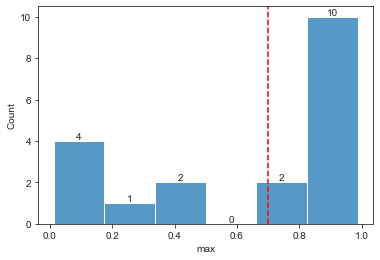

In [62]:
sns.set_style('ticks')
fig, ax = plt.subplots()
ax = sns.histplot(x = 'max', data = df_test)
plt.axvline(0.7, 0,700, c = 'r', ls = '--')
for container in ax.containers:
    ax.bar_label(container)

In [ ]:
#Load the fine-tuned BART model
from transformers import BartForSequenceClassification

model = BartForSequenceClassification.from_pretrained("../BART_model", problem_type="multi_label_classification", num_labels=2)